<a href="https://colab.research.google.com/github/Kiarashmo/Sudoku_Solver_OpenCV-ImageProcessing_course_project/blob/main/notebooks/Sudoku_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Perspective Transform function

In [14]:
import cv2
import copy
import torch
import imutils
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border

In [15]:
img = cv2.imread("sudoku_test2.jpg")
output_size = (450, 450)

In [16]:
def perspective_transform(img, output_size):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to binarize the image(returns threshhold value and threshold img)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) #(src, thresh_value, max_val, threshhold_type)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(img, contours, -1, (0, 255, 0), 2) #src, contours, -1:draw all contours, color, thickness
    # plt.imshow(img2)

    # Find the largest contour (the Sudoku board)
    largest_contour = max(contours, key=cv2.contourArea)

    # Perimeter of the largest contour found in the image
    peri = cv2.arcLength(largest_contour, True)
    '''
    largest_contour: is the contour whose perimeter will be calculated.
    closed: specifies whether the contour is closed (True) or open (False).
    '''

    # Get the corners of the Sudoku board
    approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)
    # print(approx)
    # cv2.drawContours(img, approx, -1, (0, 255, 0), 10) #src, contours, -1:draw all contours, color, thickness
    # plt.imshow(img2)

    # Reorder the corners in a clockwise direction starting from the top-left corner
    ordered_corners = np.zeros_like(approx)
    sum_coords = approx.sum(axis=2)
    ordered_corners[0] = approx[np.argmin(sum_coords)]
    ordered_corners[2] = approx[np.argmax(sum_coords)]
    diff_coords = np.diff(approx, axis=2)
    ordered_corners[1] = approx[np.argmin(diff_coords)]
    ordered_corners[3] = approx[np.argmax(diff_coords)]

    # Reshape the ordered corners to (4, 2) shape
    ordered_corners = np.float32(ordered_corners.reshape((4, 2)))

    # Define the destination points for perspective transformation
    dest_points = np.float32([[0, 0], [output_size[0], 0], [output_size[0], output_size[1]], [0, output_size[1]]])
    Matrix = cv2.getPerspectiveTransform(ordered_corners, dest_points)

    # Apply the perspective transformation to the original image
    output = cv2.warpPerspective(img, Matrix, output_size)

    return output

#### Testing the perspective function

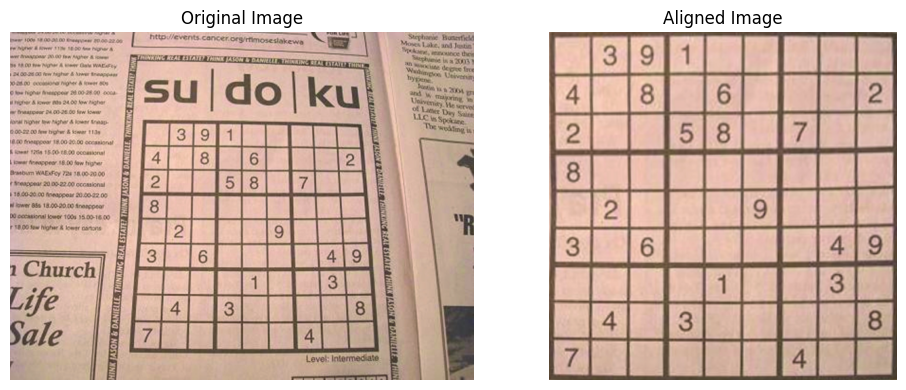

In [17]:
output = perspective_transform(img, output_size)

# Display the original image and the aligned image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image')
plt.axis('off')

plt.tight_layout()
plt.show()

#### Dividing the output image to 81 image

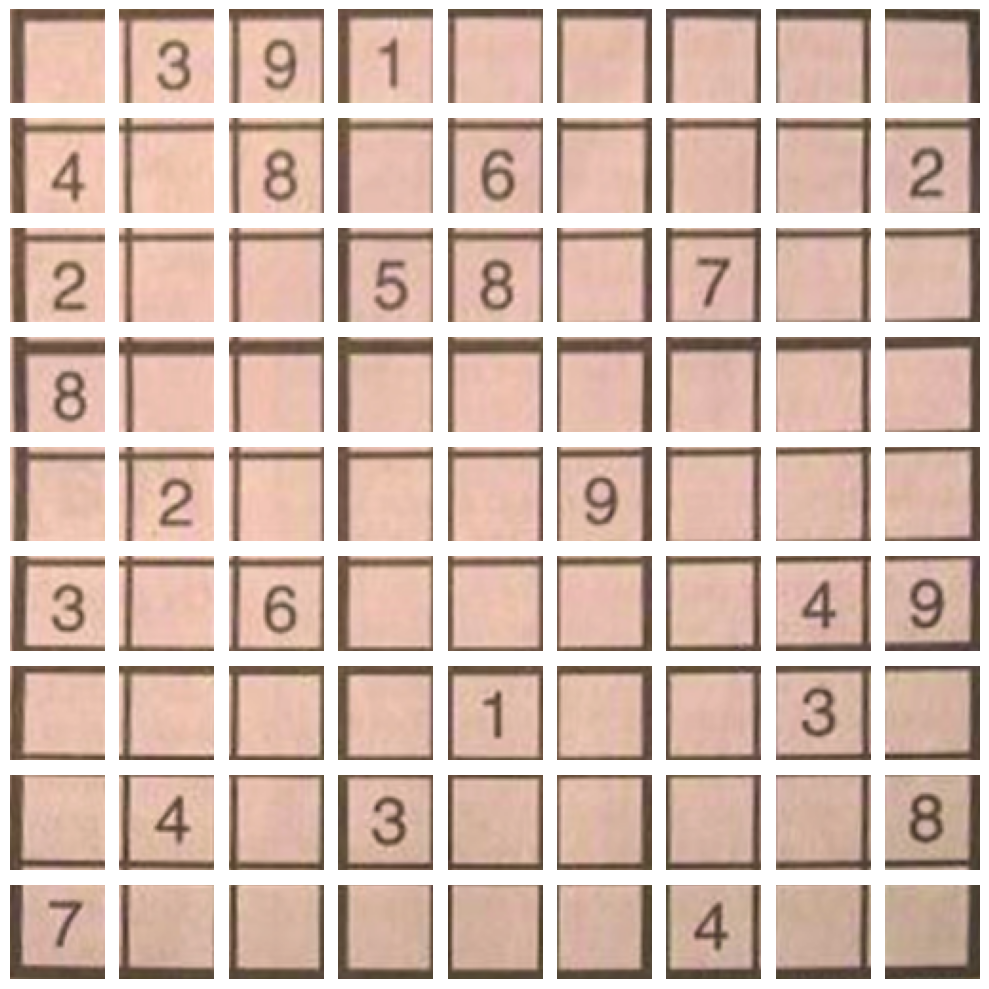

In [18]:
grid_size = 9
cell_size = output_size[0] // grid_size
cells = []

for i in range(grid_size):
    row = []
    for j in range(grid_size):
        cell = output[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
        row.append(cell)
    cells.append(row)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        ax = axes[i, j]
        ax.imshow(cv2.cvtColor(cells[i][j], cv2.COLOR_BGR2RGB))
        ax.axis('off')

plt.tight_layout()
plt.show()

### Preprocess the cells and load the model

In [19]:
def extract_digit(cell, debug=False):
    gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)

    if debug:
        cv2.imshow("Cell Thresh", thresh)
        cv2.waitKey(0)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return None

    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)

    if percentFilled < 0.03:
        return None

    digit = cv2.bitwise_and(thresh, thresh, mask=mask)

    # Centering starts here
    x, y, w, h = cv2.boundingRect(c)
    cropped_digit = digit[y:y+h, x:x+w]
    size = max([w, h])
    centered_digit = np.zeros((size, size), dtype="uint8")
    centered_digit[int((size-h)/2):int((size-h)/2) + h, int((size-w)/2):int((size-w)/2) + w] = cropped_digit

    # If debug is enabled, show the centered digit
    if debug:
        cv2.imshow("Centered Digit", centered_digit)
        cv2.waitKey(0)

    return centered_digit


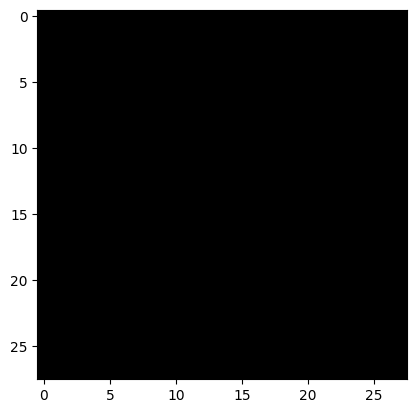

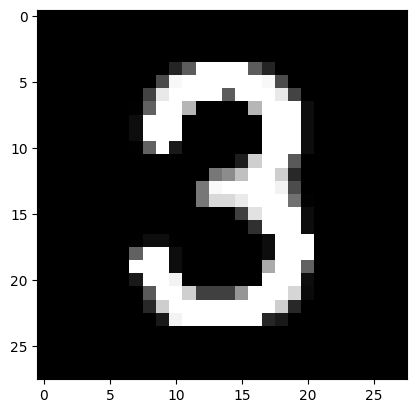

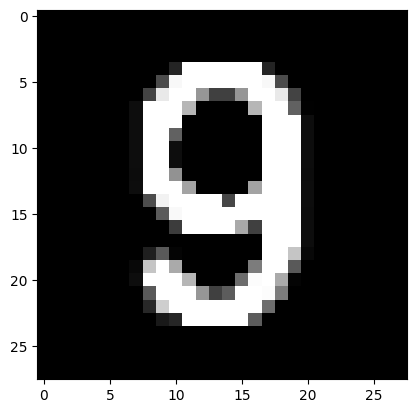

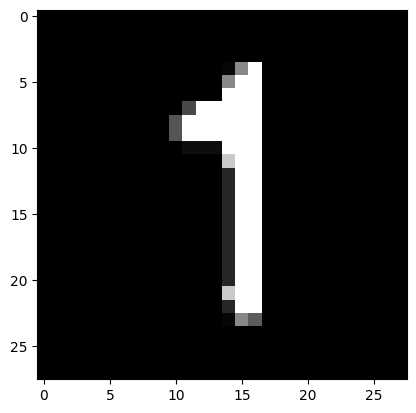

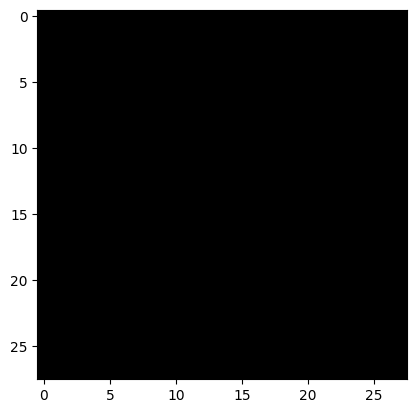

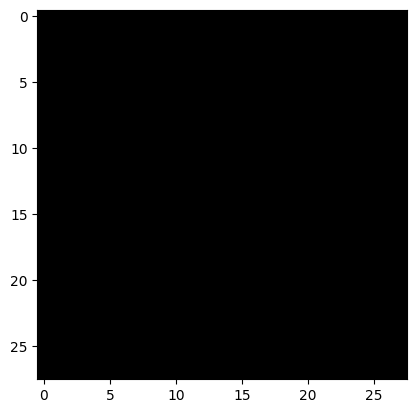

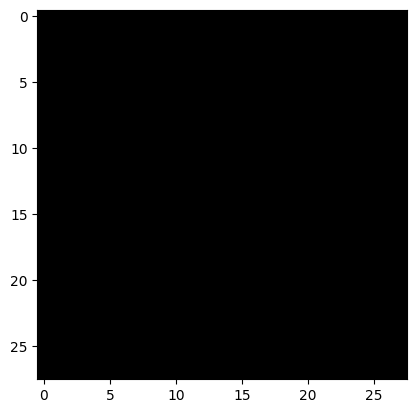

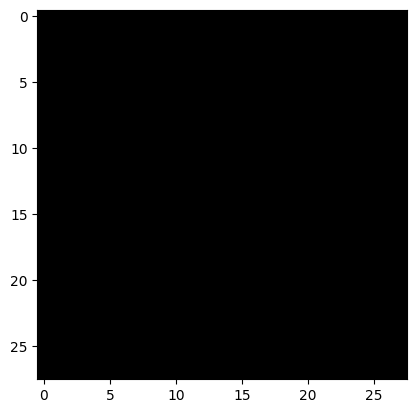

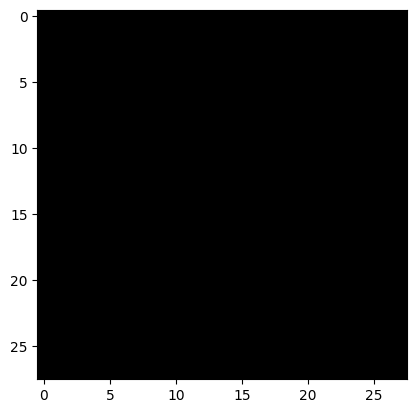

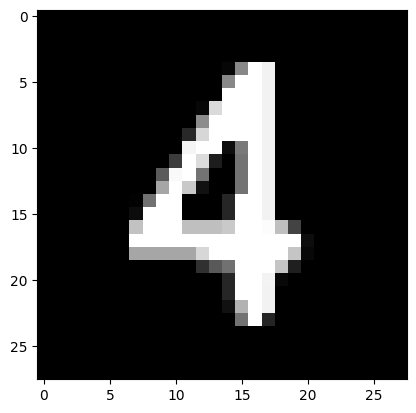

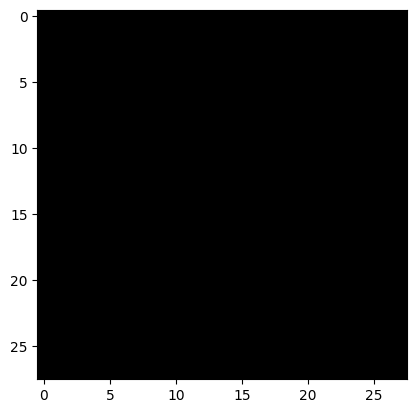

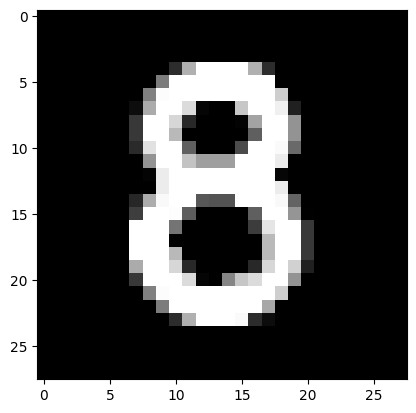

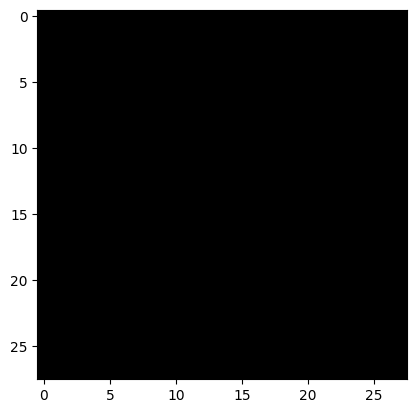

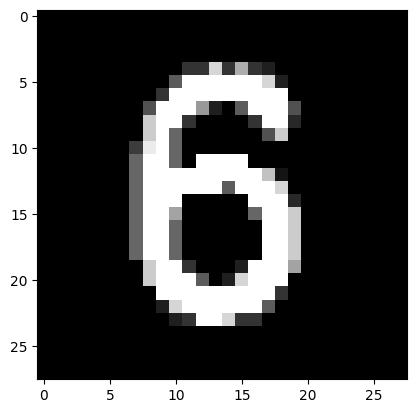

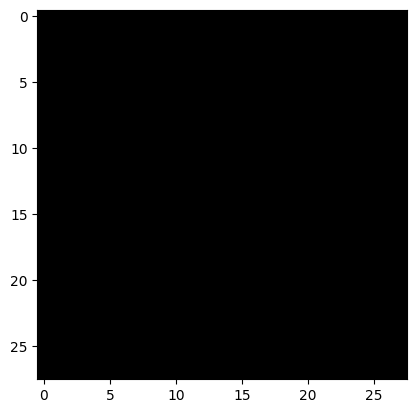

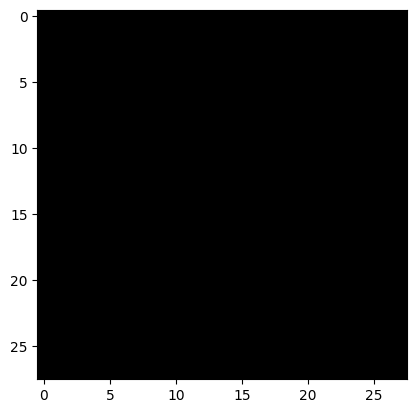

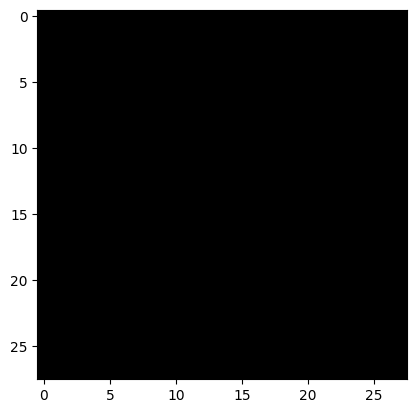

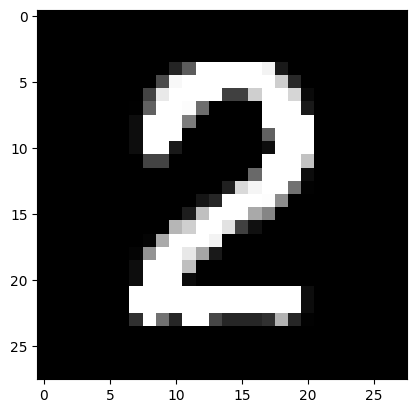

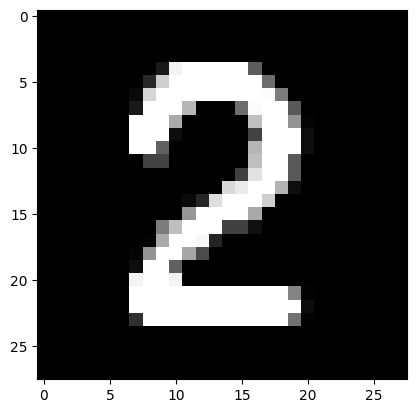

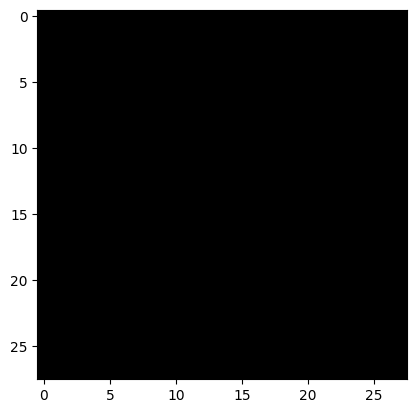

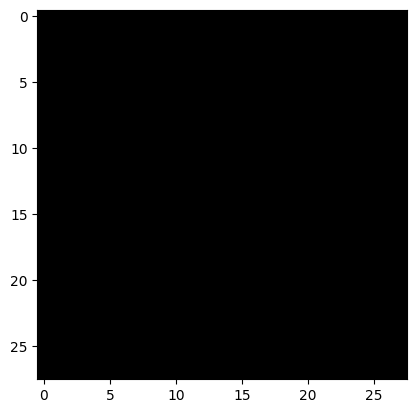

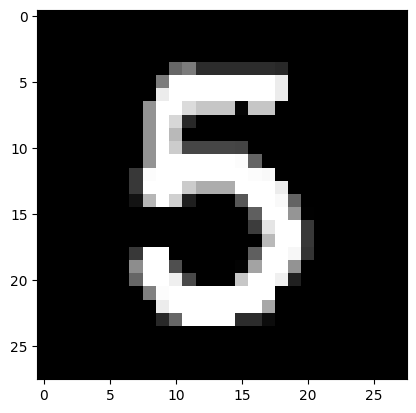

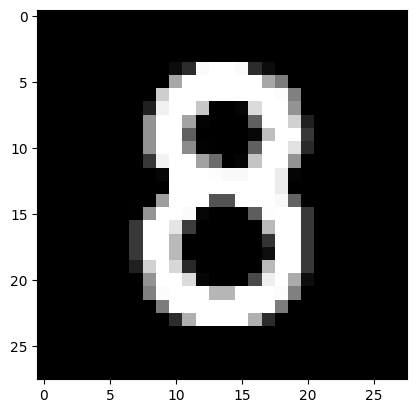

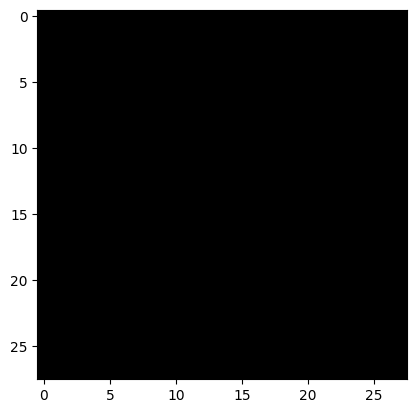

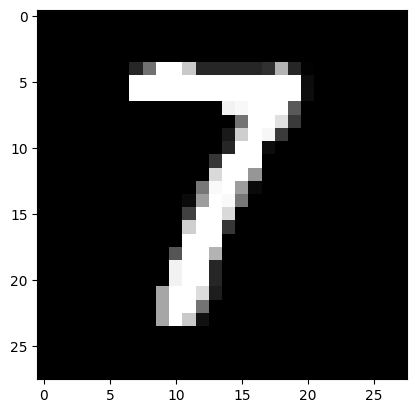

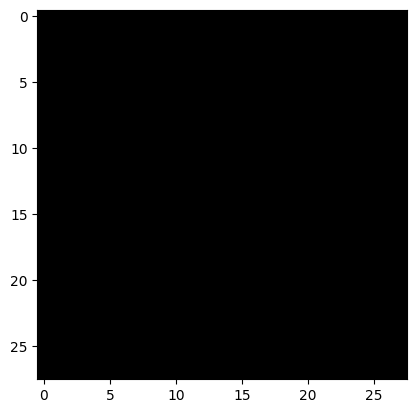

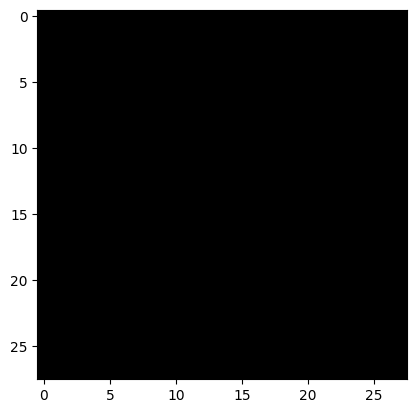

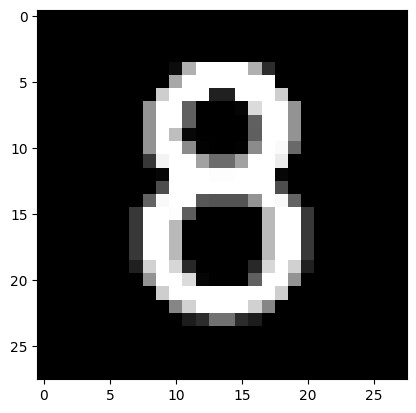

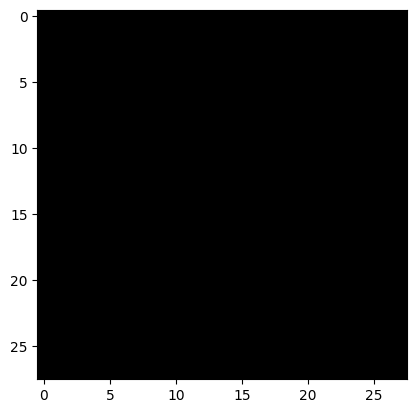

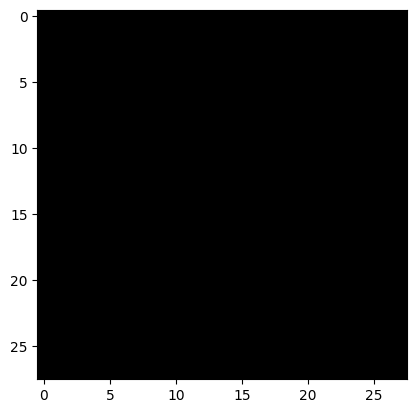

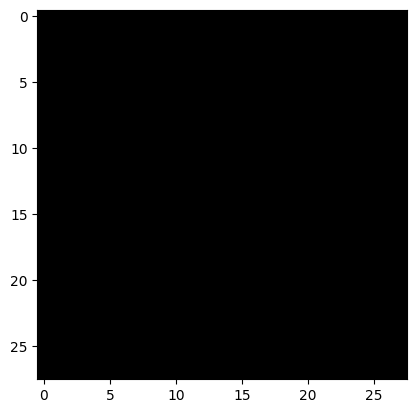

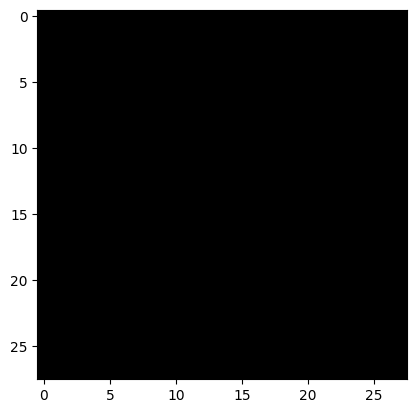

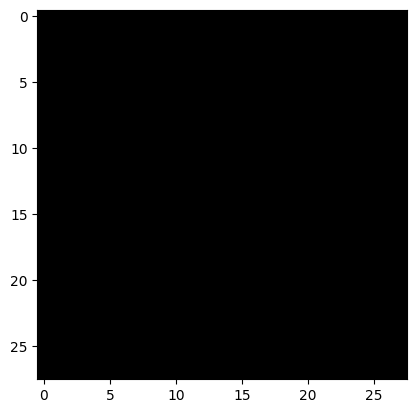

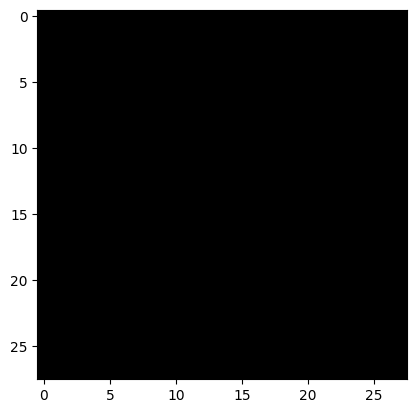

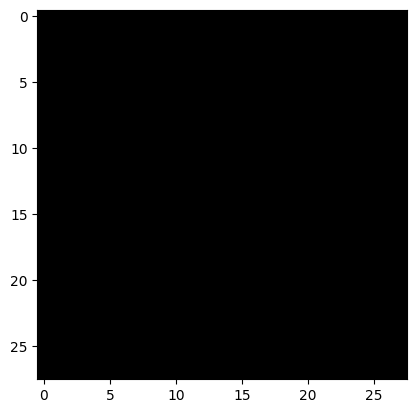

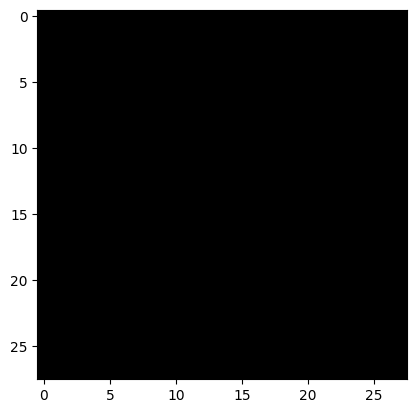

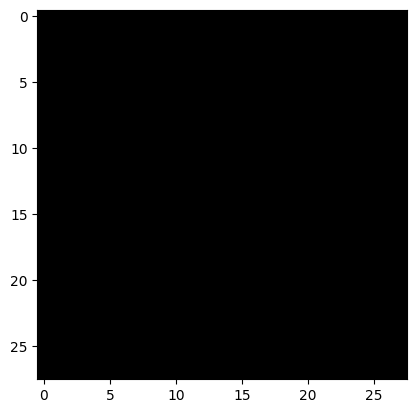

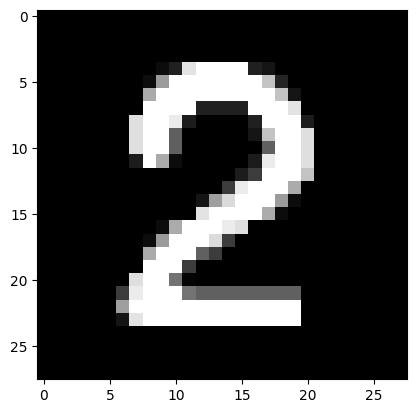

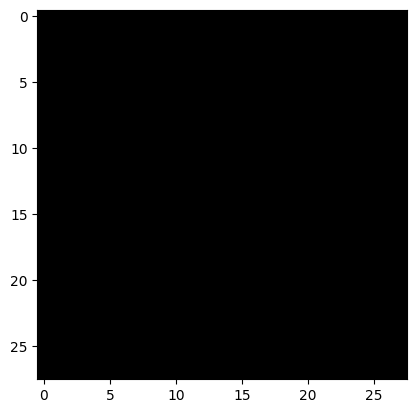

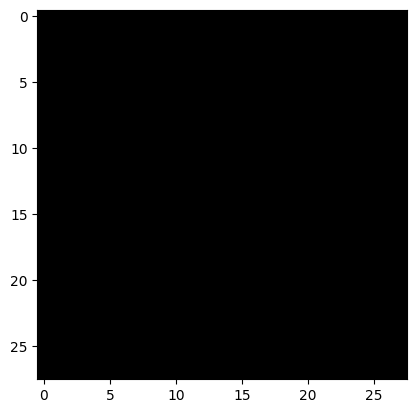

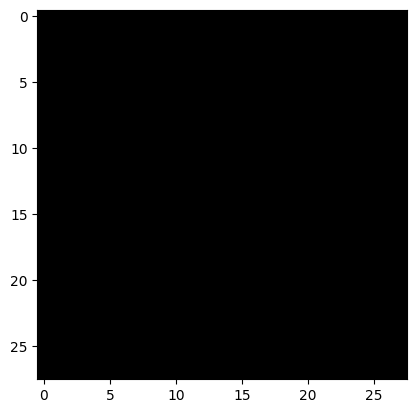

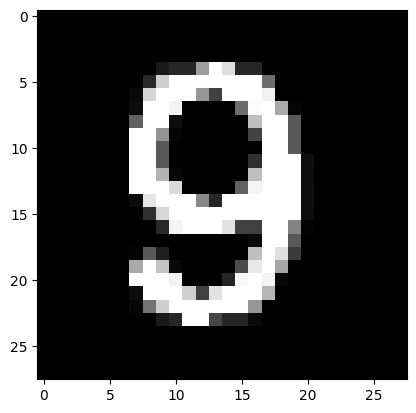

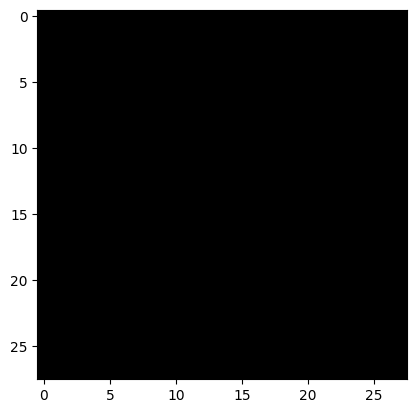

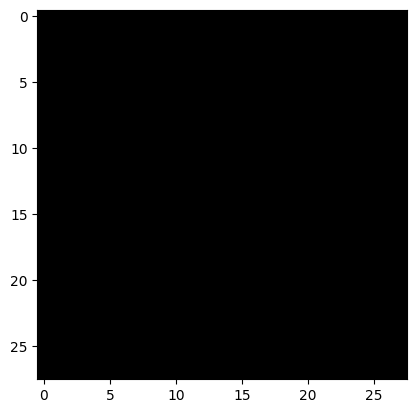

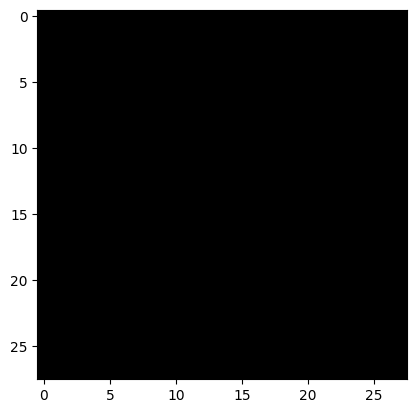

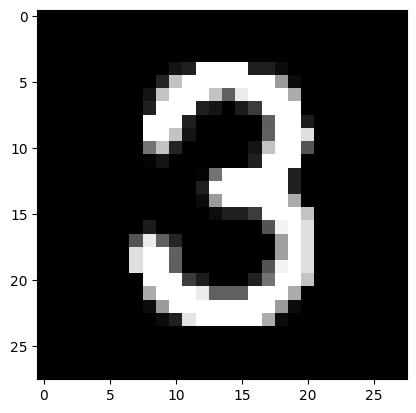

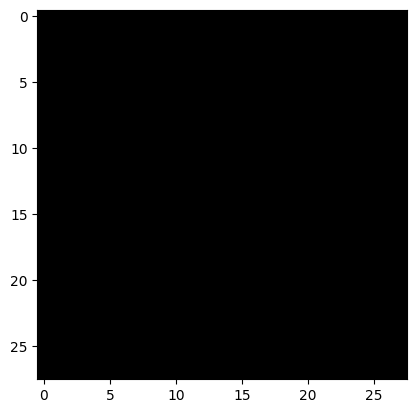

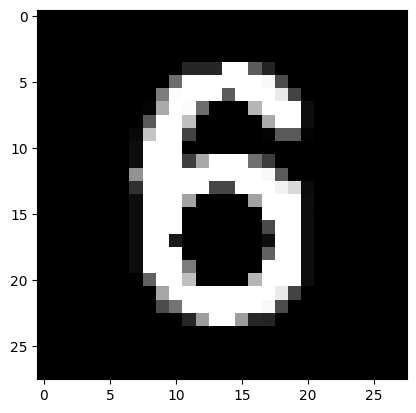

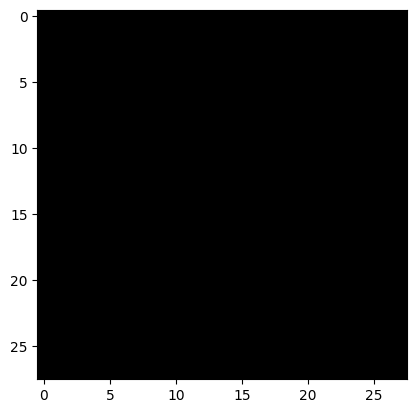

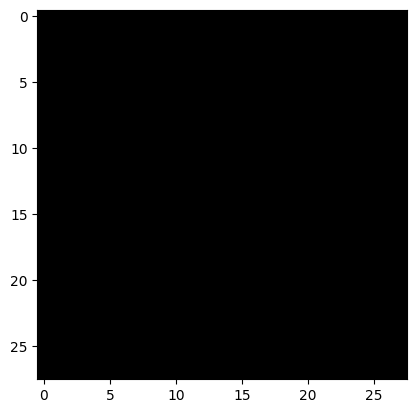

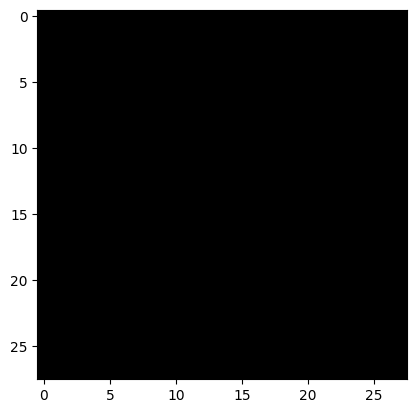

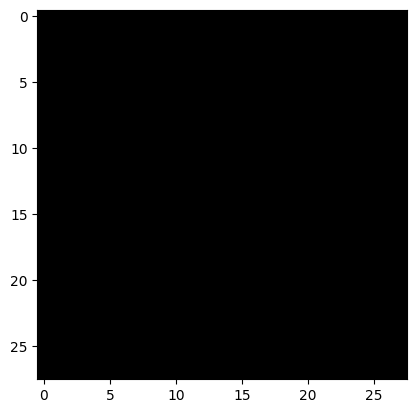

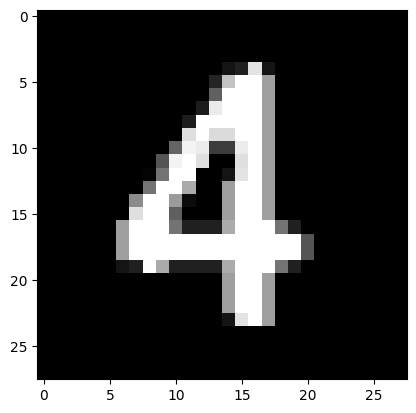

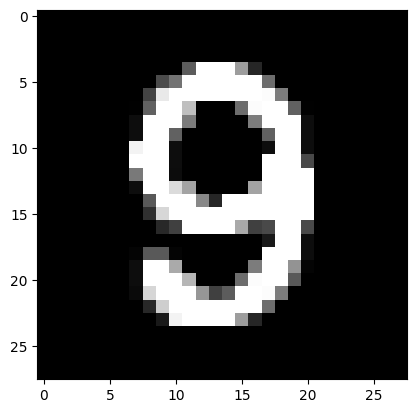

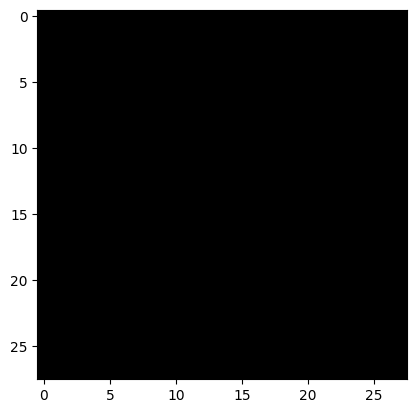

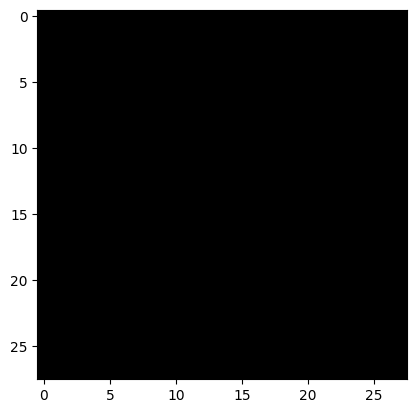

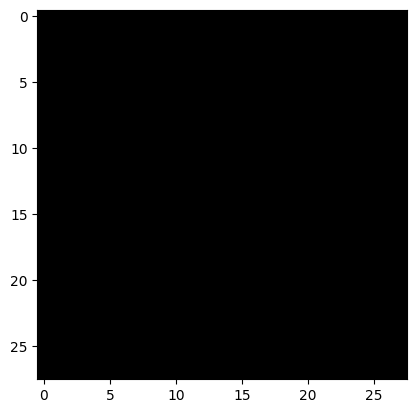

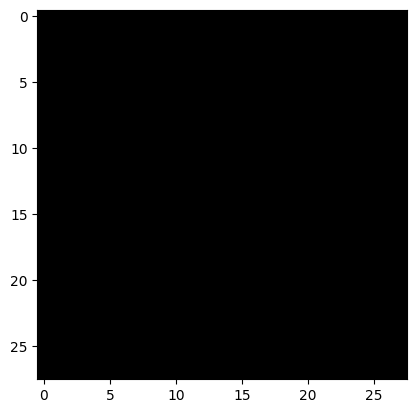

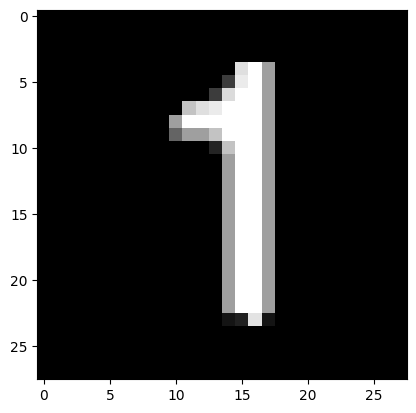

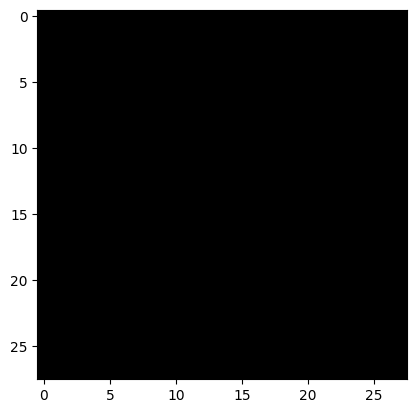

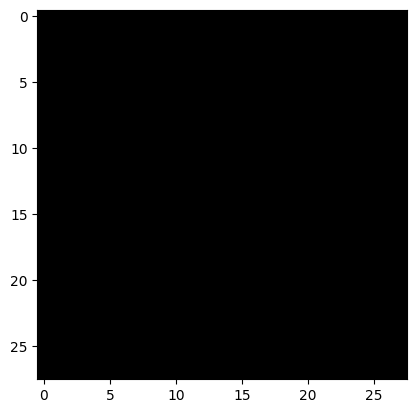

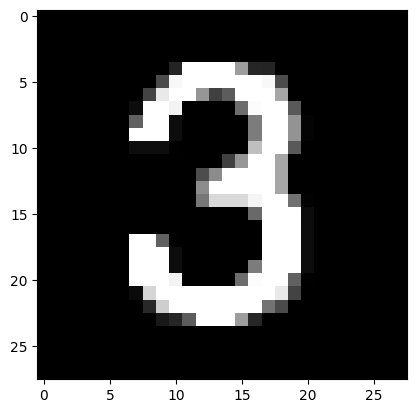

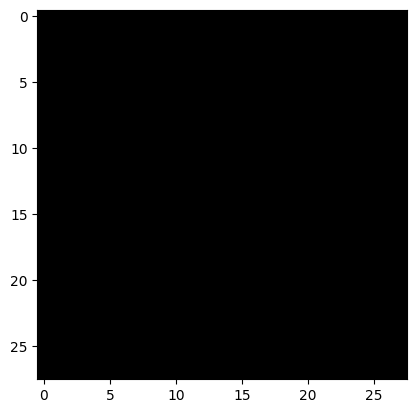

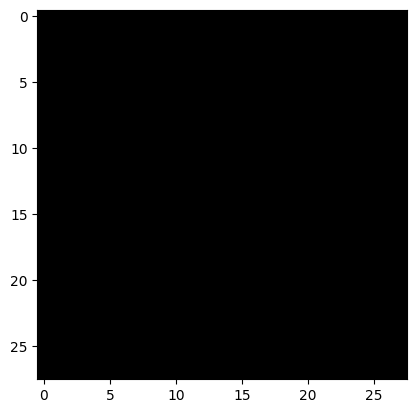

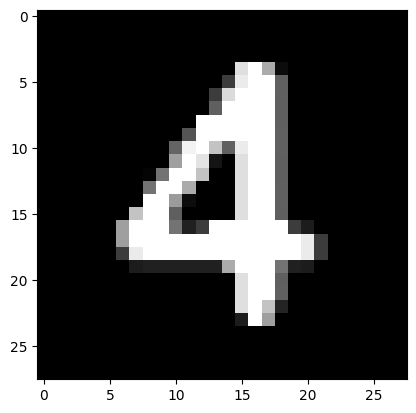

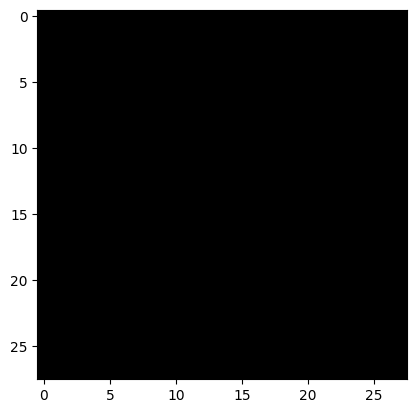

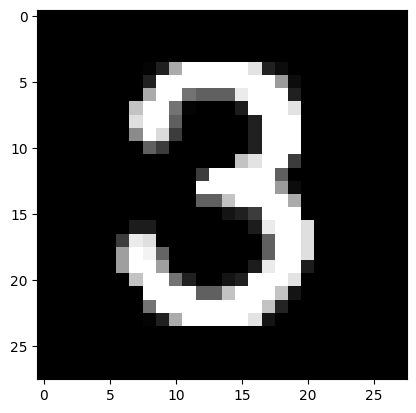

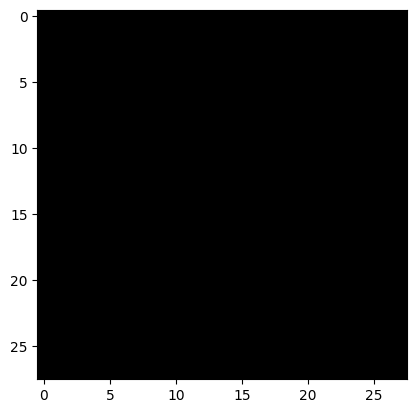

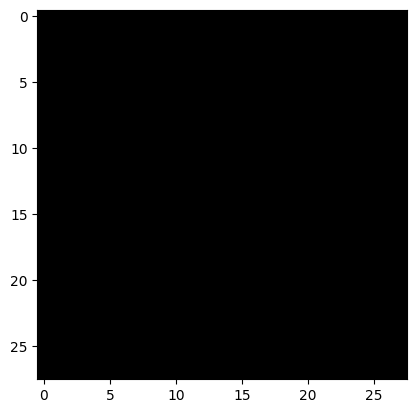

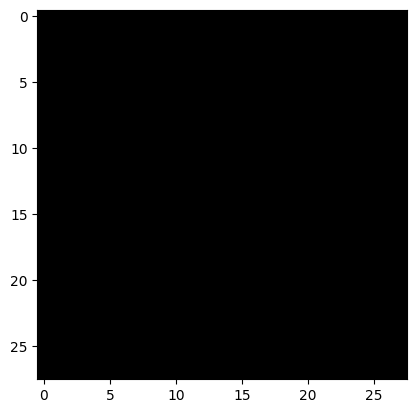

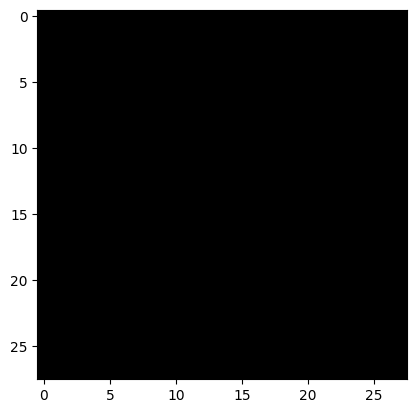

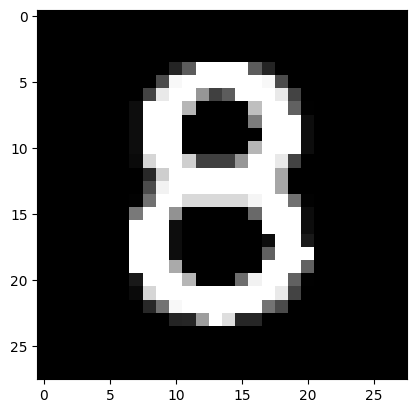

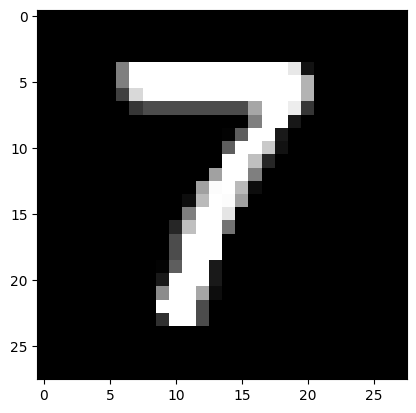

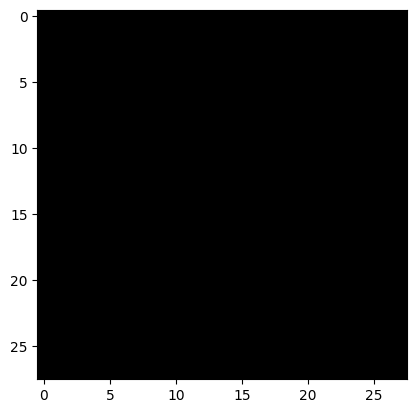

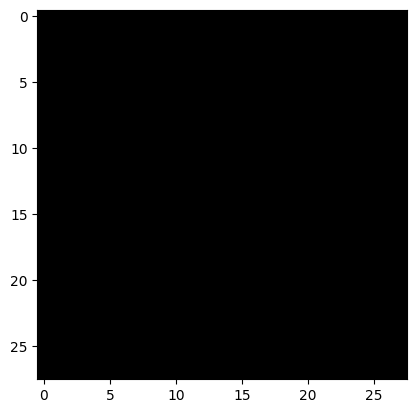

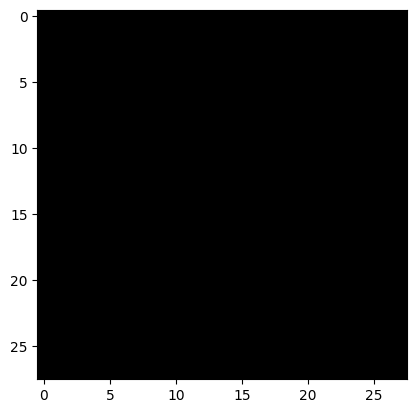

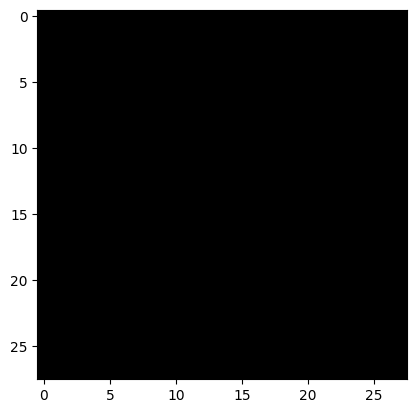

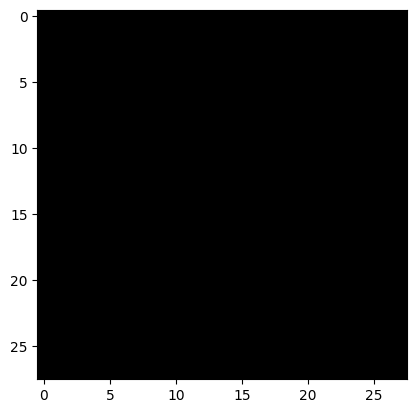

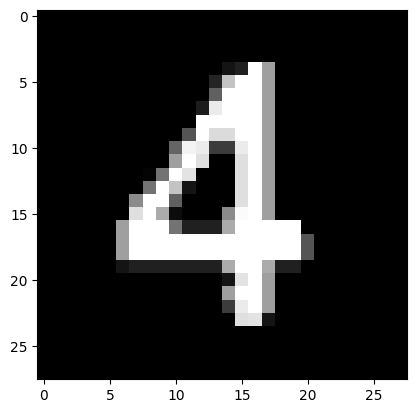

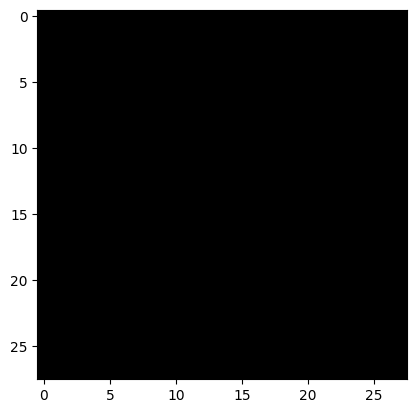

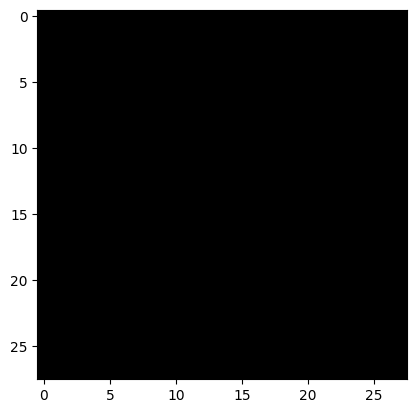

In [20]:
def preprocess_cell(cell):
    digit = extract_digit(cell)

    # If no digit was found, return None or a tensor of zeros
    if digit is None:
        return torch.zeros((1, 1, 28, 28), dtype=torch.float)

    # Resize the centered digit to be 20x20
    resized_digit = cv2.resize(digit, (20, 20))

    # Pad to 28x28
    final_digit = np.zeros((28, 28), dtype=resized_digit.dtype)
    final_digit[4:24, 4:24] = resized_digit

    # Normalize to [0, 1]
    normalized_digit = (final_digit / 255.0)

    # Convert to PyTorch tensor and add batch and channel dimensions
    tensor_digit = torch.tensor(normalized_digit).float().unsqueeze(0).unsqueeze(0)

    return tensor_digit


for row in cells:
    for cell in row:
        preprocessed_cell = preprocess_cell(cell)
        plt.imshow(preprocessed_cell.squeeze(), cmap='gray')
        plt.show()

In [21]:
# Define the path to the saved model
model_path = 'mnist_model.pth'

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Linear(3 * 3 * 128, 1000)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

model = CNN()

state_dict = torch.load(model_path, map_location=torch.device('cpu'))

model.load_state_dict(state_dict)

# If CUDA is available, send the model to the GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, ker

In [22]:
def is_empty(cell):
    threshold = 0.05
    return torch.mean(cell) < threshold

sudoku_numbers = []

for row in cells:
    row_numbers = []
    for cell in row:
        preprocessed_cell = preprocess_cell(cell).to(device)

        if is_empty(preprocessed_cell):
            row_numbers.append(0)  # use 0 to represent empty cells
        else:
            with torch.no_grad():
                output = model(preprocessed_cell)
                _, predicted = torch.max(output.data, 1)
                row_numbers.append(predicted.item())

    sudoku_numbers.append(row_numbers)

def print_sudoku(board):
    for i in range(len(board)):
        if i % 3 == 0 and i != 0:
            print(".....................")

        for j in range(len(board[0])):
            if j % 3 == 0 and j != 0:
                print("|", end=" ")

            if j == len(board[0])-1:
                print(board[i][j])
            else:
                print(str(board[i][j]) + " ", end="")

print_sudoku(sudoku_numbers)

0 3 9 | 1 0 0 | 0 0 0
4 0 8 | 0 6 0 | 0 0 2
2 0 0 | 5 8 0 | 7 0 0
.....................
8 0 0 | 0 0 0 | 0 0 0
0 2 0 | 0 0 9 | 0 0 0
3 0 6 | 0 0 0 | 0 4 9
.....................
0 0 0 | 0 1 0 | 0 3 0
0 4 0 | 3 0 0 | 0 0 8
7 0 0 | 0 0 0 | 4 0 0


### Solver

In [23]:
def findEmpty(board):
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)  # row, col
    return None

def isValid(board, num, pos):
    row, col = pos

    for i in range(len(board[0])):
        if board[row][i] == num and col != i:
            return False

    for i in range(len(board)):
        if board[i][col] == num and row != i:
            return False

    blockStart_x = 3 * (row // 3)
    blockStart_y = 3 * (col // 3)

    for i in range(blockStart_x, blockStart_x + 3):
        for j in range(blockStart_y, blockStart_y + 3):
            if board[i][j] == num and (row, col) != (i, j):
                return False

    return True

def solve(board):
    blank = findEmpty(board)

    if not blank:
        return True
    else:
        row, col = blank

    for i in range(1, 10):
        if isValid(board, i, blank):
            board[row][col] = i

            if solve(board):
                return True

            board[row][col] = 0

    return False

print(solve(sudoku_numbers))
print_sudoku(sudoku_numbers)

True
5 3 9 | 1 7 2 | 6 8 4
4 7 8 | 9 6 3 | 1 5 2
2 6 1 | 5 8 4 | 7 9 3
.....................
8 9 7 | 6 4 5 | 3 2 1
1 2 4 | 8 3 9 | 5 7 6
3 5 6 | 7 2 1 | 8 4 9
.....................
9 8 5 | 4 1 6 | 2 3 7
6 4 2 | 3 5 7 | 9 1 8
7 1 3 | 2 9 8 | 4 6 5
